In [55]:
import re
import random
import pandas as pd
import hashlib

In [56]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [57]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
PP365,127.707883,63.853941,2
PnP Powershell,255.701974,6.728999,38
Vocab,291.237297,26.476118,11
Azure Functions + Visual Studio,315.187752,22.513411,14
Audit Report Tracker (Sharepoint List),326.970200,20.435637,16
Taxes,371.257943,92.814486,4
OData,475.056833,33.932631,14
Debugging in VS Code,513.993311,22.347535,23
Azure AI Search,548.877064,39.205505,14
Powershell Modules,879.514822,29.317161,30


# Histogram

44599.96


<Axes: >

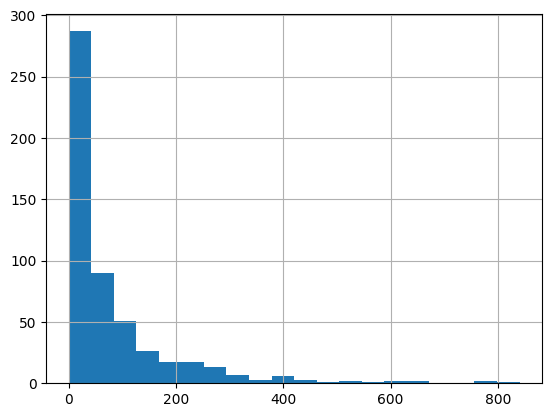

In [58]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [59]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [60]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [61]:
frequency = existing_cards['head'].value_counts(ascending=True)

existing_cards = pd.merge(
    left=existing_cards,
    right=frequency.rename('frequency'),
    left_on='head', right_index=True,
    how='left'
)
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
existing_cards['age'] = existing_cards['age'] * -1


existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 531


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
131,PP365,System-Assigned Managed Identity\nA type of ma...,66ea1257c8446ccb130d030d7803c521,-101.797743,63.853941,-101.797743,127.707883,0.257776,2,101.797743
327,PP365,Webhooks\nHTTP callbacks triggered by specific...,5d6d9baf5b01b2319afe755c092c33f0,-25.910140,63.853941,-101.797743,127.707883,0.257776,2,101.797743
73,Taxes,An S Corporation is a type of corporation that...,a9ded590b9e96fb191b2481dbe4810ba,-172.980365,92.814486,-172.980365,371.257943,0.415905,4,172.980365
119,Taxes,The main differences between an S Corp and a C...,8e72b5147de814d1d749b12081a5a07b,-112.250648,92.814486,-172.980365,371.257943,0.415905,4,172.980365
184,Taxes,"U.S. persons, including citizens, residents, c...",d49a0f63d33fd28e4c5717e6d708a705,-65.849439,92.814486,-172.980365,371.257943,0.415905,4,172.980365
372,Taxes,Taxation: Pass-Through Entities (PTEs) themsel...,1363e717d4866d881bc4e4e790a0d013,-20.177490,92.814486,-172.980365,371.257943,0.415905,4,172.980365
1,Azure AI Foundry,Compute and quota allocation is managed as sha...,beb447d769b004f37eb5bf2ed80915c2,-774.373291,229.979570,-774.373291,1839.836557,0.334760,8,774.373291
3,Azure AI Foundry,"When using Azure AI Foundry portal, you can di...",6a609b8085870b5f2159093a52131196,-637.010738,229.979570,-774.373291,1839.836557,0.334760,8,774.373291
62,Azure AI Foundry,Managed compute resources and managed virtual ...,e934d445d91e51cd66eca6274432dbba,-195.820324,229.979570,-774.373291,1839.836557,0.334760,8,774.373291
114,Azure AI Foundry,While most of the resources used by Azure AI F...,38bd277c25b531dcc2916d5f39ffd661,-114.082180,229.979570,-774.373291,1839.836557,0.334760,8,774.373291


# Focus on one header

In [62]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [63]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [64]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [65]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [66]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [67]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age Max

In [68]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [69]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [70]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [71]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
131,PP365,System-Assigned Managed Identity\nA type of ma...,66ea1257c8446ccb130d030d7803c521,-101.797743,63.853941,-101.797743,127.707883,0.257776,2,101.797743
327,PP365,Webhooks\nHTTP callbacks triggered by specific...,5d6d9baf5b01b2319afe755c092c33f0,-25.910140,63.853941,-101.797743,127.707883,0.257776,2,101.797743
73,Taxes,An S Corporation is a type of corporation that...,a9ded590b9e96fb191b2481dbe4810ba,-172.980365,92.814486,-172.980365,371.257943,0.415905,4,172.980365
119,Taxes,The main differences between an S Corp and a C...,8e72b5147de814d1d749b12081a5a07b,-112.250648,92.814486,-172.980365,371.257943,0.415905,4,172.980365
184,Taxes,"U.S. persons, including citizens, residents, c...",d49a0f63d33fd28e4c5717e6d708a705,-65.849439,92.814486,-172.980365,371.257943,0.415905,4,172.980365
372,Taxes,Taxation: Pass-Through Entities (PTEs) themsel...,1363e717d4866d881bc4e4e790a0d013,-20.177490,92.814486,-172.980365,371.257943,0.415905,4,172.980365
1,Azure AI Foundry,Compute and quota allocation is managed as sha...,beb447d769b004f37eb5bf2ed80915c2,-774.373291,229.979570,-774.373291,1839.836557,0.334760,8,774.373291
3,Azure AI Foundry,"When using Azure AI Foundry portal, you can di...",6a609b8085870b5f2159093a52131196,-637.010738,229.979570,-774.373291,1839.836557,0.334760,8,774.373291
62,Azure AI Foundry,Managed compute resources and managed virtual ...,e934d445d91e51cd66eca6274432dbba,-195.820324,229.979570,-774.373291,1839.836557,0.334760,8,774.373291
114,Azure AI Foundry,While most of the resources used by Azure AI F...,38bd277c25b531dcc2916d5f39ffd661,-114.082180,229.979570,-774.373291,1839.836557,0.334760,8,774.373291


In [72]:
existing_cards.head(10)['age'].sum()

-2220.2523583345073